# SV model with variational particle filter (stochastic MAP only)

In [7]:
import matplotlib.pyplot as plt
import torch
import pandas as pd
pd.set_option('precision', 4)

import ptvi

dtype = torch.float64
nparticles = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
data_seed, algo_seed = 1234, 1234
params = dict(a=1., b=0., c=.95)
T = 100

In [9]:
model = ptvi.FilteredStochasticVolatilityModelFreeProposal(
    input_length=T, num_particles=nparticles, resample=True, dtype=dtype, device=device)
model

Stochastic volatility model with parameters {a, b, c}:
	x_t = exp(a * z_t/2) ε_t        t=1,…,100
	z_t = b + c * z_{t-1} + ν_t,    t=2,…,100
	z_1 = b + 1/√(1 - c^2) ν_1
	where ε_t, ν_t ~ Ν(0,1)

Filter with 8 particles; AR(1) proposal params {d, e, f}:
	z_t = d + e * z_{t-1} + f η_t,  t=2,…,100
	z_1 = d + f/√(1 - e^2) η_1
	where η_t ~ Ν(0,1)

In [10]:
torch.manual_seed(data_seed)
y, z_true = model.simulate(**params)

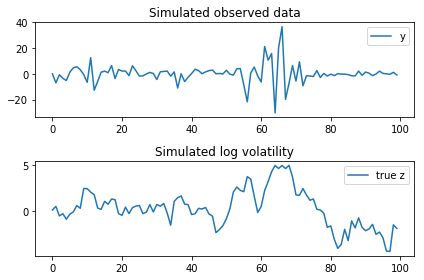

In [11]:
plt.subplot(211); plt.plot(y.cpu().numpy(), label='y')
plt.title('Simulated observed data')
plt.legend();
plt.subplot(212); plt.plot(z_true.cpu().numpy(), label='true z')
plt.legend()
plt.title('Simulated log volatility');
plt.tight_layout()

In [12]:
torch.manual_seed(algo_seed)
trace = ptvi.PointEstimateTracer(model)
fit = ptvi.stoch_opt(model, y, tracer=trace)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Stochastic optimization for Particle filtered stochastic volatility model
  - Searching for point estimates only
  - Using torch.float64 precision on cpu
  - Minimum supremum growth heuristic (min_steps=500, patience=20, skip=10, ε=0.1)
  - Adam optimizer with param groups:
    group 0. lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed stochastic loss = -355.4
       1. smoothed stochastic loss = -351.8
       2. smoothed stochastic loss = -350.0
       4. smoothed stochastic loss = -344.3
       8. smoothed stochastic loss = -335.1
      16. smoothed stochastic loss = -326.9
      32. smoothed stochastic loss = -318.8
      64. smoothed stochastic loss = -316.5
     128. smoothed stochastic loss = -315.0
     256. smoothed stochastic loss = -312

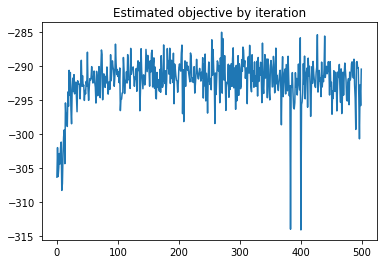

In [7]:
trace.plot_objectives()

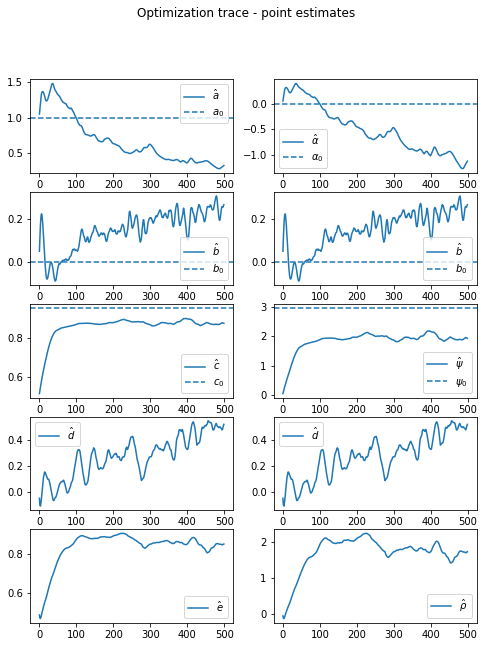

In [8]:
trace.plot(figsize=[8,10], true=params)

In [9]:
fit.summary(true=params)

,estimate,true
a,0.3230,1.00
b,0.2645,0.00
c,0.8731,0.95
d,0.5222,NaN
e,0.8483,NaN
